# All In One Place

## 0.0. Requirements

### 0.1. Imports

In [ ]:
import pickle
import numpy as np
import pandas as pd

from glob import glob
from umap.umap_ import UMAP

from matplotlib import pyplot as plt

from pyspark.sql import types
from pyspark.sql import SparkSession
from pyspark.sql import functions as pf
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import RobustScalerModel
from pyspark.ml.clustering import GaussianMixtureModel
from pyspark.ml.regression import RandomForestRegressionModel

### 0.2. Aux Functions

In [70]:
def apply_robust_scaler(df, cols):

    scalers = glob("../src/features/*_robust_*")

    for col in cols:
        
        vec = VectorAssembler(
            inputCols=[col],
            outputCol=f"vec_{col}"
        )

        df = vec.transform(df)

        robust_scaler = RobustScalerModel.load([k for k in scalers if k.split("/")[-1].startswith(col)][0])

        df = robust_scaler.transform(df)

        df = df.drop(f"vec_{col}")

    return df

def apply_vectorizing(df, selected_features=["features", "customerid"]):
    df = df.select(selected_features[1:] + [k for k in df.columns if k.startswith("vec")])

    scaled_features = [k for k in df.columns if k.startswith("vec")]

    vec = VectorAssembler(
        inputCols=scaled_features,
        outputCol="features"
    )

    df_vector = vec.transform(df).select(selected_features)

    return df_vector

### 0.3. Read Data

In [2]:
base_columns = [
    "InvoiceNo",
    "StockCode",
    "Description",
    "Quantity",
    "InvoiceDate",
    "UnitPrice",
    "CustomerID",
    "Country"
]

data_path = "/home/grc/arep/insiders_clustering/data/Ecommerce.csv"

In [ ]:
spark = SparkSession.builder \
        .master("local[4]") \
        .config("spark.driver.memory", "4g") \
        .config("spark.executor.memory", "4g") \
        .appName("insiders") \
        .getOrCreate()

In [5]:
df_raw = spark.read.format("csv").option("header", "true").option("inferSchema" , "true").load(data_path)

df_raw = df_raw.select(base_columns)

In [12]:
# Simulation with "New" Clients

df_raw = df_raw.filter(
    pf.col("CustomerID").isin(
        [17389,15447,14450,13623,
         13285,16339,14570,16386,15100]
    )
) 

In [13]:
df_raw.show(5)

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|   536374|    21258|VICTORIAN SEWING ...|      32|  29-Nov-16|    10.95|     15100|United Kingdom|
|  C537656|    21258|VICTORIAN SEWING ...|     -12|   5-Dec-16|    10.95|     15100|United Kingdom|
|   537767|    21258|VICTORIAN SEWING ...|      32|   6-Dec-16|    10.95|     15100|United Kingdom|
|  C539260|    21258|VICTORIAN SEWING ...|      -7|  14-Dec-16|    10.95|     15100|United Kingdom|
|  C540109|   85071A|BLUE CHARLIE+LOLA...|    -150|   2-Jan-17|     2.95|     17389|United Kingdom|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
only showing top 5 rows



## 1.0. Data Preprocessing

### 1.1. Rename Columns

In [14]:
df1 = df_raw.select([pf.col(k).alias(k.lower().replace(" ", "_").strip()) for k in df_raw.columns])

### 1.2. Change Dtypes

In [15]:
df1.printSchema()

root
 |-- invoiceno: string (nullable = true)
 |-- stockcode: string (nullable = true)
 |-- description: string (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- invoicedate: string (nullable = true)
 |-- unitprice: double (nullable = true)
 |-- customerid: integer (nullable = true)
 |-- country: string (nullable = true)



In [16]:
df1 = df1.withColumn(
    "invoicedate",
    pf.to_date(pf.unix_timestamp(pf.col("invoicedate"), "d-MMM-yy").cast("timestamp"))
)

### 1.3. Fill Missing Values

In [17]:
df1.select(
    [pf.count(pf.when(pf.isnull(pf.col(k)), 1)).alias(k) for k in df1.columns]
).show(2)

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|invoiceno|stockcode|description|quantity|invoicedate|unitprice|customerid|country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|          0|       0|          0|        0|         0|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



In [20]:
# Remove Description and customer id null :(
df1 = df1.filter(
    pf.col("customerid").isNotNull() &
    pf.col("description").isNotNull()
)

### 1.4. Normalization Rows

In [21]:
for col in [k.name for k in df1.schema if k.dataType.typeName() in ['string']]:
    df1 = df1.withColumn(
        col,
        pf.regexp_replace(pf.lower(pf.trim(pf.col(col))), " ", "_")
    )

## 2.0. Business Data Filtering

### 2.1. Filtering Rows and Columns

In [23]:
filter_stock_codes = ['l', 'm', 'bank_charges', 'd', 'c', '', 'post', 'pads', 'dot', 'cruk']

In [24]:
df1 = df1.select(
    "invoiceno",
    "stockcode",
    "quantity",
    "invoicedate",
    "unitprice",
    "customerid",
    "country"
).filter(
    (pf.col("unitprice") > 0.04) &
    (~pf.col("stockcode").isin(filter_stock_codes)) &
    (~pf.col("country").isin(["european_community", "unspecified"])) & 
    (~pf.col("customerid").isin(
        [16446, 12346, 15749, 15098, 15749]
    ))
)

In [25]:
df2_returns = df1.filter(pf.col("quantity") < 0)
df2_purchases = df1.filter(pf.col("quantity") > 0)

## 3.0. Feature Engineering

In [37]:
df_ref = df1.select("customerid").distinct()

### 3.1. Gross Revenue

Unit price * quantity

In [38]:
df2_purchases = df2_purchases.withColumn(
    "gross_revenue",
    pf.round(pf.col("quantity") * pf.col("unitprice"), 3)
)

df_gross_revenue = df2_purchases.groupBy("customerid").agg(pf.sum(pf.col("gross_revenue")).alias("gross_revenue"))

df_ref = df_ref.join(df_gross_revenue, on="customerid", how="left")

### 3.2. Recency

Quantity of days util last purchase

In [39]:
df_recency = df2_purchases.groupBy("customerid").agg(pf.max(pf.col("invoicedate")).alias("last_purchase"))

df_recency = df_recency.withColumn(
    "max_invoicedate",
    pf.lit(df2_purchases.select(pf.max(pf.col("invoicedate"))).collect()[0][0])
)

df_recency = df_recency.withColumn(
    "recency_days",
    pf.datediff(pf.col("max_invoicedate"), pf.col("last_purchase"))
)

df_ref = df_ref.join(df_recency.select("customerid", "recency_days"), on="customerid", how="left")

### 3.3. Sum of Item Quantity Purchase

In [40]:
df_qtd_items = df2_purchases.groupBy("customerid").agg(pf.sum(pf.col("quantity")).alias("qtde_total_items"))

df_ref = df_ref.join(df_qtd_items, on="customerid", how="left")

### 3.4. Qtd Returns

In [41]:
df_returns = df2_returns.groupBy("customerid").agg(pf.sum("quantity").alias("qtde_returns"))

df_returns = df_returns.withColumn(
    "qtde_returns",
    pf.col("qtde_returns") * -1
)

df_ref = df_ref.join(df_returns, on="customerid", how="left")

### 3.5. Quantity of Invoices

In [42]:
df_invoices = df2_purchases.groupBy("customerid").agg(pf.count_distinct(pf.col("invoiceno")).alias("qtde_invoices"))

df_ref = df_ref.join(df_invoices, on="customerid", how="left")

### 3.6. Check Null Values

In [43]:
df_ref.show()

+----------+------------------+------------+----------------+------------+-------------+
|customerid|     gross_revenue|recency_days|qtde_total_items|qtde_returns|qtde_invoices|
+----------+------------------+------------+----------------+------------+-------------+
|     17389|31833.679999999993|           0|            7612|         170|           34|
|     15447|            155.17|         330|              85|        null|            1|
|     14450|            483.25|         180|             241|        null|            3|
|     13623| 747.7800000000001|          30|             294|           4|            5|
|     13285|2709.1199999999994|          23|            2051|        null|            4|
|     16339|109.95000000000002|         284|              23|        null|            1|
|     14570| 217.2099999999999|         280|              94|        null|            2|
|     16386|             317.2|          28|             224|        null|            2|
|     15100|         

In [45]:
# If returns is none, the customer never returned nothing
df_ref = df_ref.na.fill(value=0, subset=["qtde_returns"])

In [47]:
df_ref = df_ref.filter((~pf.isnull(pf.col("gross_revenue"))))

In [ ]:
df_ref.select(
    [pf.count(pf.when(pf.isnull(pf.col(k)), 1)).alias(k) for k in df_ref.columns]
).show()

In [ ]:
df_ref = df_ref.select(
    ["customerid",
    "gross_revenue",
    "recency_days",
    "qtde_total_items",
    "qtde_returns",
    "qtde_invoices"]
)

## 4.0. Data Preparation

In [49]:
df4 = df_ref.select([pf.col(k) for k in df_ref.columns])

In [73]:
df4_tree = apply_robust_scaler(df4, df4.columns[2:])
df4_tree = apply_vectorizing(df4_tree, ["features", "customerid", "gross_revenue"])
df4_tree.show(2)

+--------------------+----------+------------------+
|            features|customerid|     gross_revenue|
+--------------------+----------+------------------+
|[-0.4032258064516...|     17389|31833.679999999993|
|[2.25806451612903...|     15447|            155.17|
+--------------------+----------+------------------+
only showing top 2 rows



In [74]:
df4_cluster = apply_robust_scaler(df4, df4.columns[1:])
df4_cluster = apply_vectorizing(df4_cluster)
df4_cluster.show(2, truncate=False)

+--------------------------------------------------------------------------------+----------+
|features                                                                        |customerid|
+--------------------------------------------------------------------------------+----------+
|[23.59482190847495,-0.4032258064516129,8.779126213592232,56.666666666666664,8.0]|17389     |
|[-0.3867898103637533,2.258064516129032,-0.3555825242718446,0.0,-0.25]           |15447     |
+--------------------------------------------------------------------------------+----------+
only showing top 2 rows



## 5.0. Get Random Forest Indices

In [80]:
rf2 = RandomForestRegressionModel.load("../src/features/random_forest_model.spark")

# Get Tree Indices
df_leaf = rf2.transform(
    df4_tree.select("features", "gross_revenue", "customerid"), 
    {rf2.leafCol: "leaf_indices"}
)

df_leaf.select("customerid", "leaf_indices").show(2, truncate=False)

Do not exists umap in pyspark, i need to use pandas and external package

In [82]:
# Convert Leaf vector in Pandas dataframe
df_leaf_pandas = pd.DataFrame([np.array(k[0]) for k in df_leaf.select("leaf_indices").collect()])

# Get customerid
df_leaf_customer_pandas = df_leaf.select("customerid").toPandas()

# Concat Values
df_leaf_pandas = pd.concat([df_leaf_pandas, df_leaf_customer_pandas], axis=1)

df_leaf_pandas.head(2)

### 5.1. Get Umap Reducer

In [85]:
reducer = pickle.load(open("../src/features/umap_reducer.pickle", "rb"))

embs = reducer.transform(df_leaf_pandas.iloc[:, :-1])
embs = pd.DataFrame(embs)

embs_with_customer = pd.concat([embs, df_leaf_pandas[["customerid"]]], axis=1)

embs_with_customer.head()

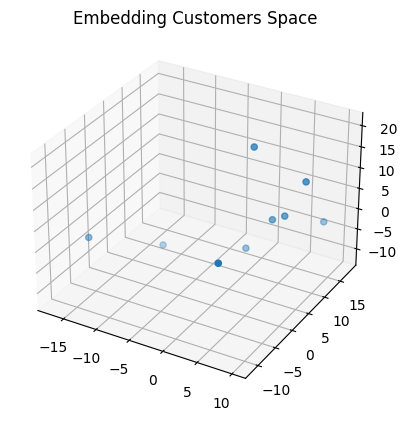

In [88]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(embs[0], embs[1], embs[2]);
ax.set_title("Embedding Customers Space");

### 5.2. Vectorize New Space

In [90]:
df5 = spark.createDataFrame(embs_with_customer)

vec = VectorAssembler(
    inputCols=["0", "1", "2"],
    outputCol="features"
)

df5 = vec.transform(df5).select("features", "customerid")

## 6.0. Get Cluster Indices

In [92]:
gmm_tuned = GaussianMixtureModel.load("../src/features/gmm_tuned.spark")

df_clusters_tuned = gmm_tuned.transform(df5)

df_clusters_tuned = df_clusters_tuned.select("customerid", "cluster")

In [97]:
df_clusters_tuned.show()

+----------+-------+
|customerid|cluster|
+----------+-------+
|     17389|      2|
|     15447|      5|
|     14450|      1|
|     13623|      4|
|     13285|      4|
|     16339|      5|
|     14570|      7|
|     16386|      7|
|     15100|      3|
+----------+-------+

